In [1]:
import torch
from torchvision import datasets
from torch.utils.data import DataLoader
from tqdm import tqdm
from sklearn.metrics import balanced_accuracy_score, ConfusionMatrixDisplay
from torchvision.transforms import transforms
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("dark")

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=transform,
)

test_dataset = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=transform,
)

In [3]:
batch_size = 32

train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size, num_workers=11, persistent_workers=True)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size, num_workers=11)

In [4]:
import torchhd as hd
d = 10_000
embedder = hd.embeddings.Projection(28 * 28, d)

In [5]:
labels = []
hypervectors = []

for batch in tqdm(train_loader):
    x, y = batch
    x = torch.nn.Flatten()(x)
    
    labels.append(y)
    hypervectors.append(embedder(x).sign())

100%|██████████| 1875/1875 [00:05<00:00, 316.14it/s]


In [6]:
labels = torch.cat(labels)
hypervectors = torch.cat(hypervectors)

/Users/jakubbednarski/Desktop/Studia/sem3/GSN/venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/jakubbednarski/Desktop/Studia/sem3/GSN/venv/lib/python3.11/site-packages/umap/umap_.py:1887: UserWarning: gradient function is not yet implemented for hamming distance metric; inverse_transform will be unavailable
  warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


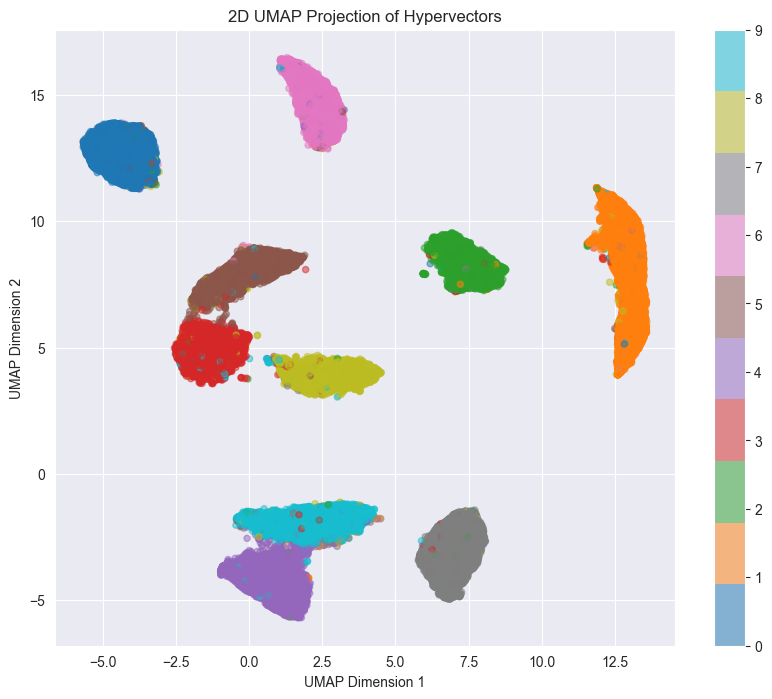

In [7]:
import umap

reducer = umap.UMAP(n_components=2, metric='hamming', min_dist=0.0, n_neighbors=15)
embedding = reducer.fit_transform(hypervectors)

# Plotting
plt.figure(figsize=(10, 8))
scatter = plt.scatter(embedding[:, 0], embedding[:, 1], c=labels, cmap='tab10', s=20, alpha=0.5)
plt.colorbar(scatter, ticks=range(10))
plt.title("2D UMAP Projection of Hypervectors")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.grid(True)
plt.show()

In [8]:
# 1. Single-pass learning

model_hypervectors = {}
for label, hypervector in tqdm(zip(labels, hypervectors), total=60_000):
    label = int(label)
    if label not in model_hypervectors:
        model_hypervectors[label] = hypervector
    else:
        model_hypervectors[label] = hd.bundle(model_hypervectors[label], hypervector)

100%|██████████| 60000/60000 [00:00<00:00, 157671.91it/s]


/Users/jakubbednarski/Desktop/Studia/sem3/GSN/venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


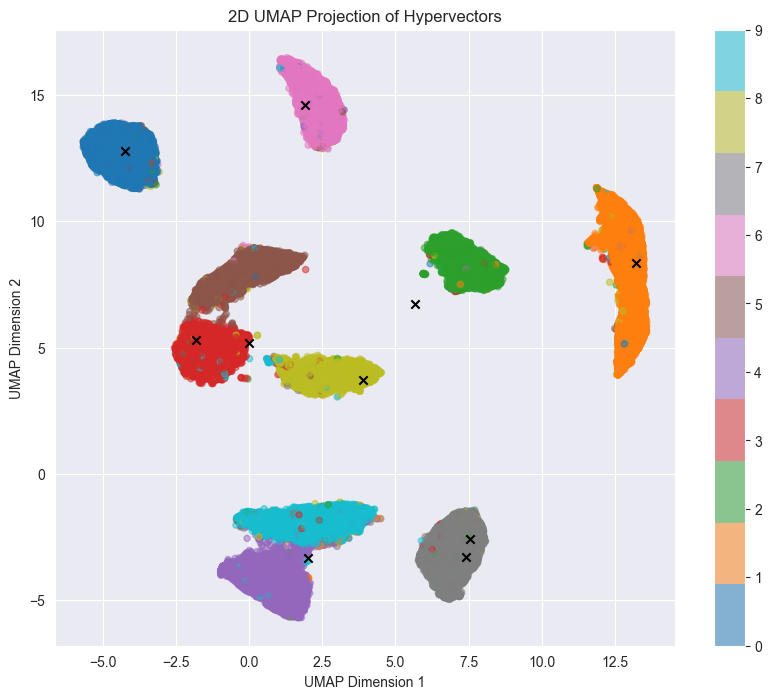

In [9]:
centroids_embedding = reducer.transform(list(model_hypervectors.values()))

plt.figure(figsize=(10, 8))
scatter = plt.scatter(embedding[:, 0], embedding[:, 1], c=labels, cmap='tab10', s=20, alpha=0.5)
plt.scatter(centroids_embedding[:, 0], centroids_embedding[:, 1], c='black', marker='x')
plt.colorbar(scatter, ticks=range(10))
plt.title("2D UMAP Projection of Hypervectors")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.grid(True)
plt.show()

In [14]:
true_labels = []
predicted_labels = []

for batch in tqdm(train_loader):
    x, y = batch
    x = torch.nn.Flatten()(x)
    
    for _y, _x in zip(y, embedder(x).sign()):
        predicted_label = max(model_hypervectors, key=lambda label: float(hd.cosine_similarity(_x, model_hypervectors[label])))
        true_labels.append(int(_y))
        predicted_labels.append(predicted_label)

100%|██████████| 1875/1875 [00:50<00:00, 36.96it/s]


Text(0.5, 1.0, 'Accuracy: 0.8195506286815991')

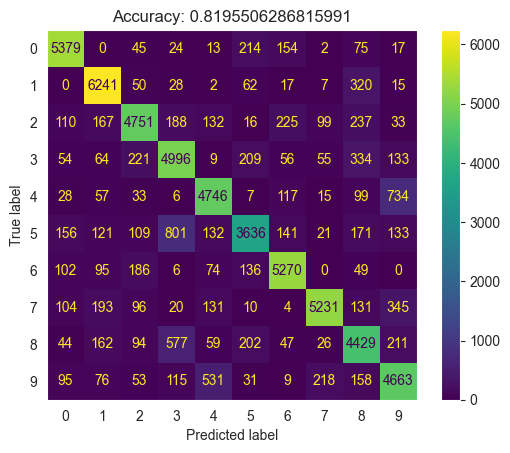

In [16]:
ConfusionMatrixDisplay.from_predictions(true_labels, predicted_labels)
plt.title(f'Accuracy: {balanced_accuracy_score(true_labels, predicted_labels)}')

In [17]:
# 2. Multi-pass learning (iterative)

for _ in range(10):
    for label, hypervector in tqdm(zip(labels, hypervectors), total=60_000):
        label = int(label)
        if label not in model_hypervectors:
            model_hypervectors[label] = hypervector
        else:
            model_hypervectors[label] = hd.bundle(model_hypervectors[label], hypervector)

100%|██████████| 60000/60000 [00:00<00:00, 156022.04it/s]


/Users/jakubbednarski/Desktop/Studia/sem3/GSN/venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


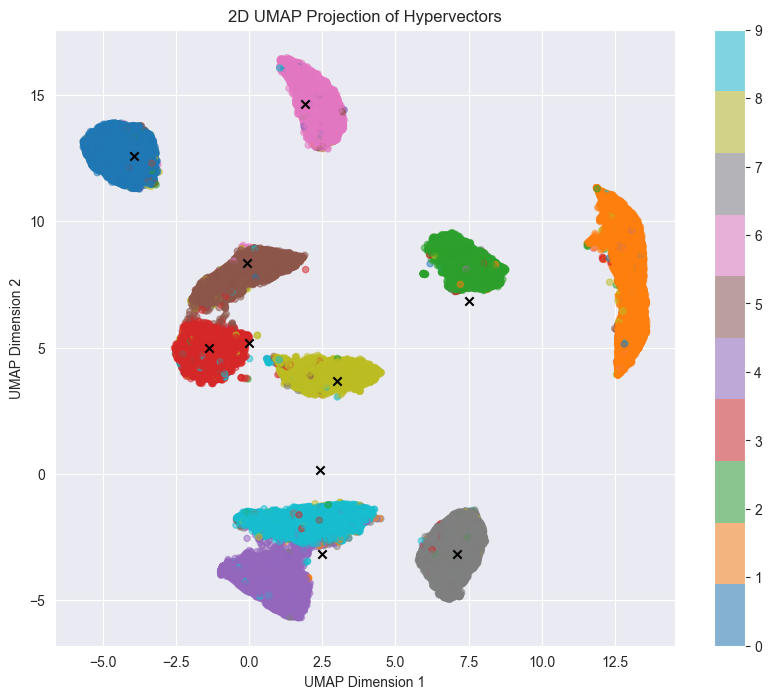

In [21]:
centroids_embedding = reducer.transform(list(model_hypervectors.values()))

plt.figure(figsize=(10, 8))
scatter = plt.scatter(embedding[:, 0], embedding[:, 1], c=labels, cmap='tab10', s=20, alpha=0.5)
plt.scatter(centroids_embedding[:, 0], centroids_embedding[:, 1], c='black', marker='x')
plt.colorbar(scatter, ticks=range(10))
plt.title("2D UMAP Projection of Hypervectors")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.grid(True)
plt.show()

In [18]:
true_labels = []
predicted_labels = []

for batch in tqdm(train_loader):
    x, y = batch
    x = torch.nn.Flatten()(x)
    
    for _y, _x in zip(y, embedder(x).sign()):
        predicted_label = max(model_hypervectors, key=lambda label: float(hd.cosine_similarity(_x, model_hypervectors[label])))
        true_labels.append(int(_y))
        predicted_labels.append(predicted_label)

100%|██████████| 1875/1875 [00:56<00:00, 33.28it/s]


Text(0.5, 1.0, 'Accuracy: 0.8195506286815991')

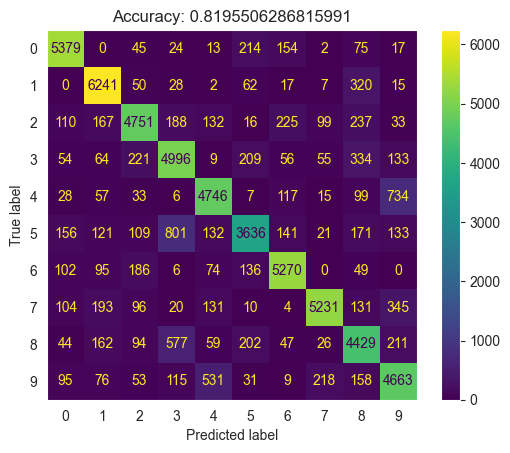

In [19]:
ConfusionMatrixDisplay.from_predictions(true_labels, predicted_labels)
plt.title(f'Accuracy: {balanced_accuracy_score(true_labels, predicted_labels)}')

In [20]:
#  3. Multi-centroid learning
centroids = []
vectors = []

for label, hypervector in tqdm(zip(labels, hypervectors), total=60_000):
    centroids_of_this_label = list(filter(lambda centroid: centroid[0] == label, centroids))
    
    if len(centroids_of_this_label) == 0:
        centroids.append([label, 1])
        vectors = torch.stack([*[vector for vector in vectors], hypervector])
    else:
        distances = hd.cosine_similarity(hypervector, vectors)
        best_idx = torch.argmax(distances)
        
        if centroids[best_idx][0] != label:
            centroids.append([label, 1])
            vectors = torch.stack([*[vector for vector in vectors], hypervector])
        else:
            vectors[best_idx] = hd.bundle(vectors[best_idx], hypervector)
            centroids[best_idx][1] += 1

100%|██████████| 60000/60000 [10:21<00:00, 96.54it/s] 


In [22]:
centroids_with_vectors = [[c[0], c[1], v] for c, v in zip(centroids, vectors)]
centroids_with_vectors.sort(key=lambda c: c[1], reverse=True)
len(centroids_with_vectors)

3328

In [23]:
filtered_centroids = []

for centroid in centroids_with_vectors:
    label, _, vector = centroid
    if len(list(filter(lambda fc: fc[0] == label, filtered_centroids))) >= 20:
        continue
        
    filtered_centroids.append([label, vector])

/Users/jakubbednarski/Desktop/Studia/sem3/GSN/venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


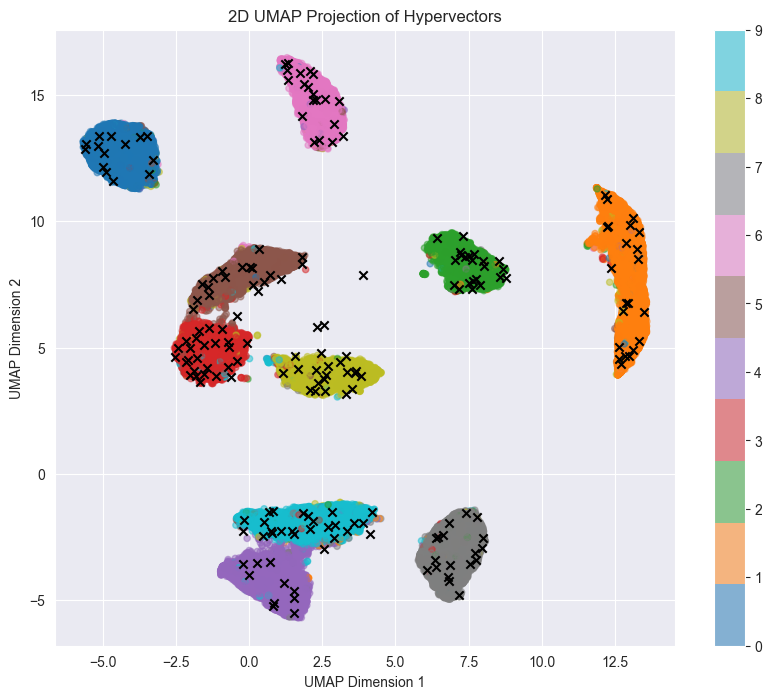

In [24]:
centroids_embedding = reducer.transform([c[1] for c in filtered_centroids])

plt.figure(figsize=(10, 8))
scatter = plt.scatter(embedding[:, 0], embedding[:, 1], c=labels, cmap='tab10', s=20, alpha=0.5)
plt.scatter(centroids_embedding[:, 0], centroids_embedding[:, 1], c='black', marker='x')
plt.colorbar(scatter, ticks=range(10))
plt.title("2D UMAP Projection of Hypervectors")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.grid(True)
plt.show()

In [30]:
true_labels = []
predicted_labels = []
vectors = torch.stack([c[1] for c in filtered_centroids])

for batch in tqdm(train_loader):
    x, y = batch
    x = torch.nn.Flatten()(x)
    
    for _y, _x in zip(y, embedder(x).sign()):
        distances = hd.cosine_similarity(_x, vectors)
        best_idx = torch.argmax(distances)
        
        true_labels.append(int(_y))
        predicted_labels.append(int(filtered_centroids[best_idx][0]))

100%|██████████| 1875/1875 [00:58<00:00, 32.14it/s]


Text(0.5, 1.0, 'Accuracy: 0.9326062413180299')

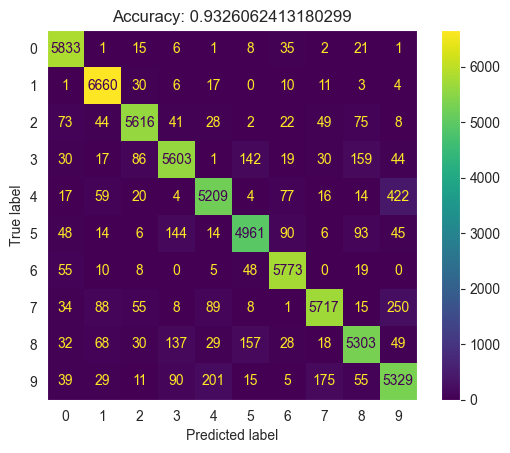

In [31]:
ConfusionMatrixDisplay.from_predictions(true_labels, predicted_labels)
plt.title(f'Accuracy: {balanced_accuracy_score(true_labels, predicted_labels)}')

In [32]:
#  3.5. Multi-centroid + Multi-pass learning
for hypervector, label in tqdm(zip(hypervectors, labels), total=60_000):
    centroids_of_this_label = list(filter(lambda fc: fc[0] == label, filtered_centroids))
    
    best_centroid = max(centroids_of_this_label, key=lambda cotl: hd.cosine_similarity(hypervector, cotl[1]))
    
    best_centroid[1] = hd.bundle(best_centroid[1], hypervector)

Creating Centroids: 60000it [01:49, 545.91it/s]


/Users/jakubbednarski/Desktop/Studia/sem3/GSN/venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


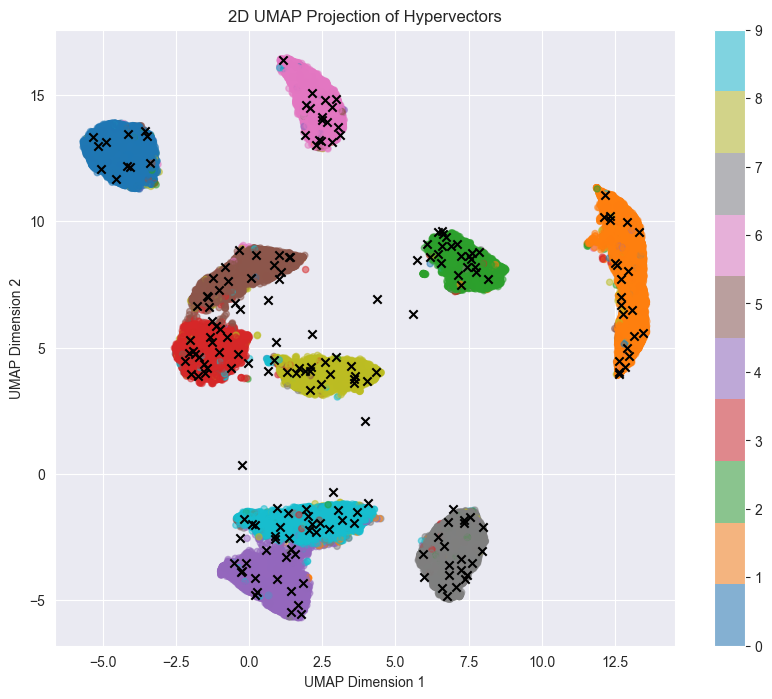

In [33]:
centroids_embedding = reducer.transform([c[1] for c in filtered_centroids])

plt.figure(figsize=(10, 8))
scatter = plt.scatter(embedding[:, 0], embedding[:, 1], c=labels, cmap='tab10', s=20, alpha=0.5)
plt.scatter(centroids_embedding[:, 0], centroids_embedding[:, 1], c='black', marker='x')
plt.colorbar(scatter, ticks=range(10))
plt.title("2D UMAP Projection of Hypervectors")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.grid(True)
plt.show()

In [34]:
true_labels = []
predicted_labels = []
vectors = torch.stack([c[1] for c in filtered_centroids])

for batch in tqdm(train_loader):
    x, y = batch
    x = torch.nn.Flatten()(x)
    
    for _y, _x in zip(y, embedder(x).sign()):
        distances = hd.cosine_similarity(_x, vectors)
        best_idx = torch.argmax(distances)
        
        true_labels.append(int(_y))
        predicted_labels.append(int(filtered_centroids[best_idx][0]))

100%|██████████| 1875/1875 [00:57<00:00, 32.40it/s]


Text(0.5, 1.0, 'Accuracy: 0.9408220980114568')

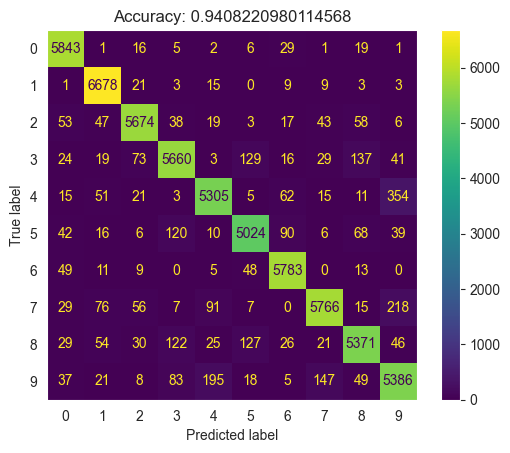

In [35]:
ConfusionMatrixDisplay.from_predictions(true_labels, predicted_labels)
plt.title(f'Accuracy: {balanced_accuracy_score(true_labels, predicted_labels)}')